In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("OPENROUTER_API_KEY")

In [2]:
#%pip install --upgrade pdfminer.six
#%pip install python-magic-bin

## Partition the Document (for olympus generated report)

In [2]:
from unstructured.partition.pdf import partition_pdf
from pdfminer.high_level import extract_text
from pdfminer.pdfparser import PDFSyntaxError


file_path = './data/report.pdf'


#parses through pdfs, returns everything in pdf into a single vector (Images, tables, text)
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True, #allows you to extract table from documents
    strategy="hi_res", #needed to extract tables

    extract_image_block_types=["Image", "Table"],
    extract_image_block_to_payload=True, #extract images and they will have metadata element that contains base64 of image, needed to send to LLM
    size = {
  "longest_edge": 1500,  # max pixels for longest side (width or height)
    },

    #enable chunking by title
    #all elements inside a title will be under a single chunk, useful for RAG
    chunking_strategy = "by_title",
    max_characters=10000, #max size of chunk is 10,000 characters
    combine_text_under_n_chars=2000, #
    new_after_n_chars=6000,

)

#so we sent the pdf file through the unstructured library, which chunked up the pdf into machine readable code 
#it extracts things like images, tables, text, titles, etc. from the document

len(chunks) #how many content blocks (chunks) did we extract from the pdf

chunks[0].metadata.orig_elements #get the first chunk and show the metadata

#this is what an image looks like in the metadata
#chunk_images = [el for el in elements if 'Image' in str(type(el))]
#chunk_images[0].to_dict() #image_base64 is what is going to get sent to our llm

  

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## Separate Extracted elements into tables, text, and images

In [3]:
texts = []
tables= []

for chunk in chunks: 
    if "Table" in str(type(chunk)): 
        tables.append(chunk)
    if "CompositeElement" in str(type(chunk)): 
        texts.append(chunk)


In [4]:
def get_images_base64(chunks): 
    images_b64=[]

    for chunk in chunks: 
        if "CompositeElement" in str(type(chunk)): 
            chunk_el = chunk.metadata.orig_elements
            chunk_images = [el for el in chunk_el if 'Image' in str(type(el))]
            for image in chunk_images: 
                images_b64.append(image.metadata.image_base64)
    
    return images_b64

images = get_images_base64(chunks)
print(images)

            #chunk_images = [el for el in elements if 'Image' in str(type(el))]
#chunk_images[0].to_dict() #image_base64 is what is going to get sent to our llm

            

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKZBJ4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA

## Check what the images look like

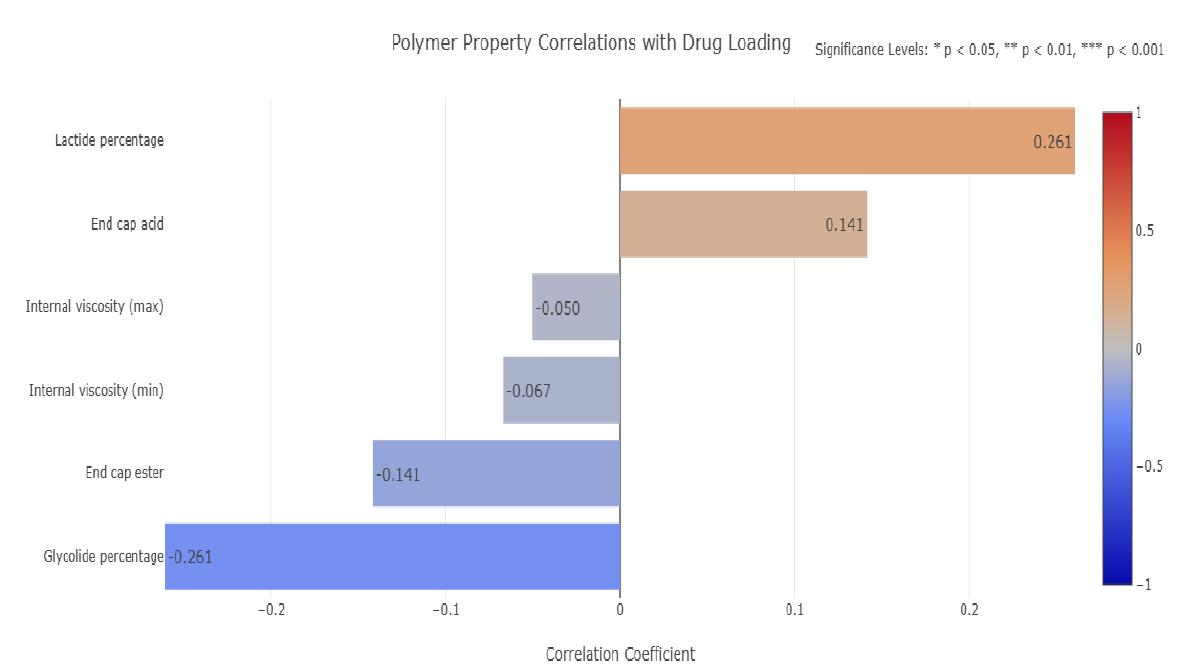

In [5]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code): 
    image_data = base64.b64decode(base64_code)
    display(Image(data=image_data))


display_base64_image(images[2])

## Summarize the Data

### Now we create a summary of each element extracted from the PDF. This summary is going to get vectorized and used in retrieval for LLM.

In [ ]:
#%pip install -Uq langchain-groq

In [6]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chat_models import ChatOpenAI

In [7]:
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}
"""

#element will be filled with the actual table/text content

prompt = ChatPromptTemplate.from_template(prompt_text) #turns the prompt into a LangChain prompt object so it can be used with the model

model = ChatOpenAI( #define the model we will use
    temperature=0.5,
    model_name="gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1",
    openai_api_key = api_key
)

summarize_chain = prompt | model | StrOutputParser() #this creates a processing chain where the input data (prompt) gets sent to the model and the output gets extracted with StrOutputParser


C:\Users\ruyek\AppData\Local\Temp\ipykernel_23528\1264165166.py:16: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI( #define the model we will use


In [8]:
#summarize the text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3}) #texts is an array that contains chunks of text, basically you get a summary of each chunk and it does it 3 at a time

#summarize the tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3}) 

### Image Summaries 

In [9]:
#This will be done differenlty than text and tables

#Change this template later to fit what Kenan wants (refer to Zelda report)
prompt_template = """
Describe the image in detail. For context, the image is part of an experiment that was conducted. Be specific about graphs, such as bar plots.
"""


image_model = ChatOpenAI( #define the model we will use
    temperature=0.5,
    model_name="gpt-4o-mini", #need to use gpt for this since this has multi-modal input
    base_url="https://openrouter.ai/api/v1",
    openai_api_key = api_key
)

messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image}"},},
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | image_model | StrOutputParser()

image_summaries = chain.batch(images)



## Link Everything together with an id and load to vector db and document store

In [ ]:
#%pip install sentence-transformers transformers accelerate torch
#%pip install langchain-huggingface



In [ ]:
#create id for every single document and add it as metadata to the summary and the document itself
#the document goes to document store (we dont embed this bc it is too large)
#the summary goes to the vector store (we embed this (create a vector for it) and goes to a vector store)
#we retrieve the summary, and then we check the id of the document in the metadata and go fetch the corresponding document in doc store
import os
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.storage.sql import SQLStore

#using a free embedding model in huggingface
model_name = "hkunlp/instructor-large"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}

hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

id_key="doc_id"


#This function checks if a project exists and if it doesn't it will create a new vectorstore and docstore for it, then return the retriever
#if it does it will simply connect to the existing ones and return the retriever

def create_new_db(project_name):
    vectorstore=Chroma(collection_name="multi_modal_rag", embedding_function=hf, persist_directory=f"./db/{project_name}/{project_name}_chroma_db") #to store summaries

    vectorstore.persist()

    sql_store = SQLStore(namespace=f"{project_name}_docstore", db_url=f"sqlite:///./db/{project_name}/{project_name}_docstore.db")
    sql_store.create_schema()
    docstore = sql_store


    retriever = MultiVectorRetriever( #MultiVectorRetriever will search the vector store for relevant results, read the doc_id, and returns the related documents from document store
            vectorstore=vectorstore,
            docstore=docstore,
            id_key=id_key
        ) 

    return retriever
    

def connect_db(project_name):

    base = f"./db/{project_name}"

    if os.path.exists(base):   #if project exists, connect to it, if it doesn't ask the user if they want to create a new project and call create_new_db

        vectorstore_path = f"./db/{project_name}/{project_name}_chroma_db"
        
        vectorstore=Chroma(collection_name="multi_modal_rag", embedding_function=hf, persist_directory=f"{vectorstore_path}") #to store summaries

        vectorstore.persist()

        sql_store = SQLStore(namespace=f"{project_name}_docstore", db_url=f"sqlite:///./db/{project_name}/{project_name}_docstore.db")
        
        docstore = sql_store
        
        
        retriever = MultiVectorRetriever( #MultiVectorRetriever will search the vector store for relevant results, read the doc_id, and returns the related documents from document store
            vectorstore=vectorstore,
            docstore=docstore,
            id_key=id_key
        )

    
    return retriever

#need to parse user query for a project name
retriever = connect_db("ava")

In [ ]:
import json
import pickle


#add text
text_ids = [str(uuid.uuid4()) for _ in text_summaries] #creates a unique id for every index in texts

summary_texts = [
    Document(page_content= summary, metadata={id_key:text_ids[i]}) for i,summary in enumerate(text_summaries)
] #creating a list of langchain document objects for each summary with a unique id

if summary_texts:     
    retriever.vectorstore.add_documents(summary_texts) #add summaries to the vectorstore
    text_pickle = [pickle.dumps(text) for text in texts]
    retriever.docstore.mset(list(zip(text_ids, text_pickle))) #stores full original texts, pairs each id with the full text, mset saves them all at once
else: 
    print("No texts found. Skipping text insertion.")

#add tables
table_ids = [str(uuid.uuid4()) for _ in table_summaries]
summary_tables = [
    Document(page_content = summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]

if summary_tables: 
    retriever.vectorstore.add_documents(summary_tables)
    table_pickle = [pickle.dumps(table) for table in tables]
    retriever.docstore.mset(list(zip(table_ids, table_pickle)))

else: 
    print("No tables found. Skipping table insertion.")

#add images
image_ids = [str(uuid.uuid4()) for _ in image_summaries]
summary_images = [
    Document(page_content = summary, metadata={id_key: image_ids[i]}) for i, summary in enumerate(image_summaries)
]

if summary_images: 
    retriever.vectorstore.add_documents(summary_images)
    image_pickle = [pickle.dumps(image) for image in images]
    retriever.docstore.mset(list(zip(image_ids, image_pickle)))
else: 
    print("No images found. Skipping image insertion.")


No tables found. Skipping table insertion.


KeyboardInterrupt: 

## Buidling the RAG pipeline now

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode
from fpdf import FPDF
from langchain_core.output_parsers import StrOutputParser

def parse_response(responses):  #bc currently the response from retriever gives us weird number/letter combos representing text and images
    b64=[]
    text=[]

    for response in responses: 
        try:
            #try to decode it and see if it is an image
            image_response = pickle.loads(response)
            b64decode(image_response)
            b64.append(image_response)
        except Exception as e:  #if its not an image, append the text to text array
            
            text.append(pickle.loads(response))

    
    return {"images": b64, "text": text}


def build_prompt(kwargs): #build the prompt that the llm will see, adds all the text and attaches images if needed
    docs_by_type = kwargs["context"]  # the output of parse_docs()
    user_question = kwargs["question"]  # the question being asked
    template = './data/template.txt'

    with open(template, 'r', encoding='utf-8',) as f:
        template_text = f.read().strip()

    context_text = ""
    # Add all the text content together
    if len(docs_by_type["text"]) > 0:
        for text_element in docs_by_type["text"]:
            context_text += text_element.text  # assume these are Document objects

    # Now build the actual prompt string
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}


    If the user asks for a final report to be generated, follow the template below. 
    Make sure the template uses images, tables, graphs where necessary. 
    Ensure you have one page decicated to title and table of contents which should include Summary, Introduction, Objectives, Methodology, Results, Conclusion.
    The report should be in a pdf format.

    Template: {template_text}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]  # first item: text

    # If there are images, add them too
    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append({
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            })

    # Wrap everything into a LangChain chat prompt
    return ChatPromptTemplate.from_messages(
        [HumanMessage(content=prompt_content)]
    )



model = ChatOpenAI( #define the model we will use
    temperature=0.5,
    model_name="gpt-4o-mini", #has to be gpt 4o mini since it can take in images and text
    base_url="https://openrouter.ai/api/v1",
    openai_api_key = api_key
)

#The chain being used (OLD ONE)
chain = (
    {
        "context": retriever | RunnableLambda(parse_response) , #runnable lambda allows for running functions with langchain

        "question": RunnablePassthrough(), #allows for questions to go through untouched, what goes in comes out the same way

    }
    | RunnableLambda(build_prompt) | model | StrOutputParser() 
     
    #build the prompt, send it to llm, and get the output as a string
)

#BETTER CHAIN USE THIS ONE
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_response), #find relevant info (documents/tables/images) and run it through parse_response
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt) #runs build_pormpt function which combines the context and question into one string for the model
        | model
        | StrOutputParser() #outputs response in a string
    )
)

In [36]:
#To generate a pdf version
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        # Set desired width for the image
        image_width = 150  # you can adjust this

        # Calculate X position to center the image
        page_width = self.w  # width of the page
        margin = self.l_margin
        x_pos = (page_width - image_width) / 2

        # Place the image
        self.image('./assets/report-header.png', x=x_pos, y=10, w=image_width)

        # Add spacing after the image
        self.ln(40) 

    # Page footer
    def footer(self):
        # Position at 1.5 cm from bottom
        self.set_y(-15)
        # Arial italic 8
        self.set_font('Arial', 'I', 8)
        # Page number
        self.cell(0, 10, 'Page ' + str(self.page_no()), 0, 0, 'C')

pdf = PDF()


Response: ### Summary

This document provides an overview of drug loading data across various formulations, highlighting correlations between different parameters and drug loading percentages. Key findings include mean and median drug loading values, significant correlations with specific additives, and variations in drug loading based on formulation parameters.

### Introduction

The study focuses on the formulation of a drug compound, investigating its loading efficiency across multiple formulations. The project addresses challenges related to optimizing drug delivery and stability, utilizing various additives and polymer amounts.

### Objectives

1. To analyze drug loading percentages across different formulations.
2. To identify correlations between formulation parameters and drug loading.
3. To categorize formulations based on single-parameter variations.
4. To recommend optimal formulations for further development.

### Methodology

- **Formulation Preparation**: Various formulat

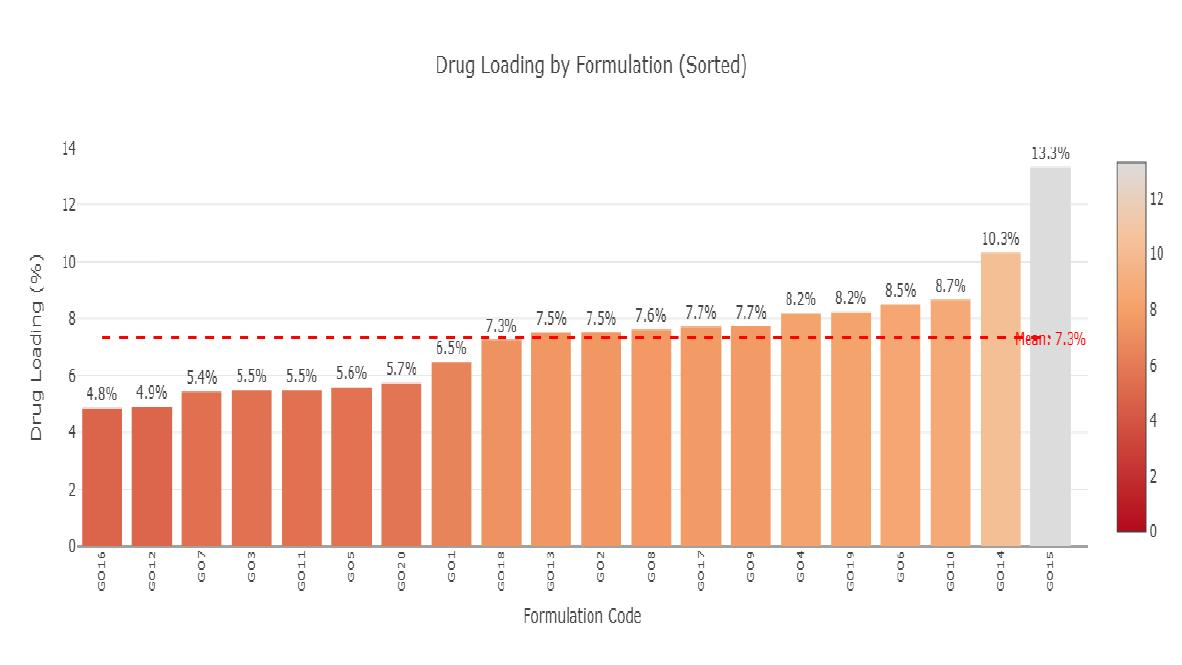

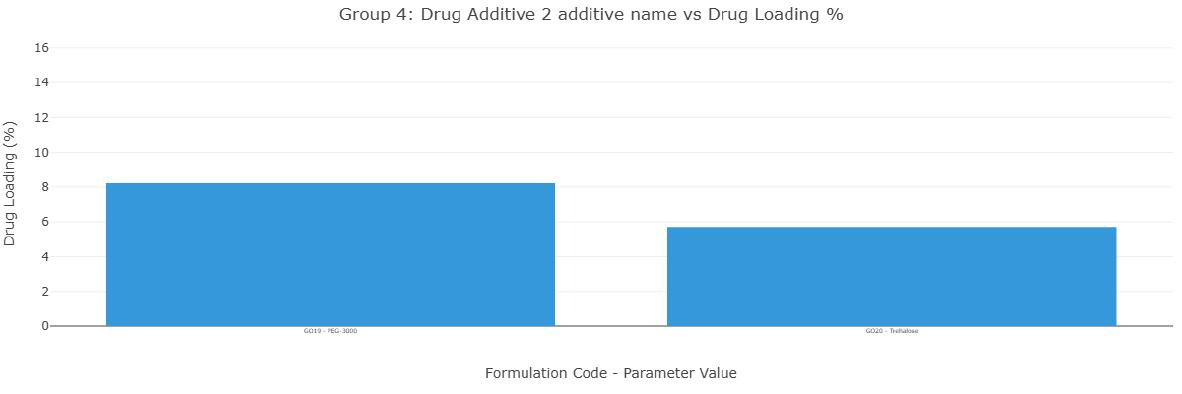

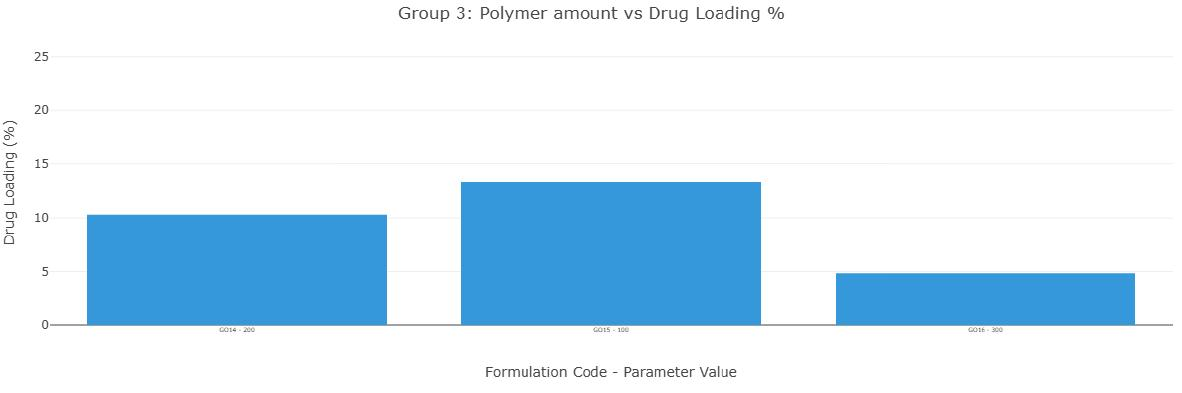

In [ ]:
response = chain_with_sources.invoke("Summarize this document for me")

report_text = response['response']

#so you can see what llm responded with
print("Response:", response['response'])

for image in response['context']['images']:
    display_base64_image(image)